# **Oxford Pets Image Segmentation with U-Net**

## Overview

In this notebook, we’ll build a Convolutional Neural Network (CNN) based on the U-Net architecture to perform image segmentation on the Oxford Pets dataset. Image segmentation allows us to identify and label each pixel in an image, which is useful for tasks that require detailed recognition, such as separating pets from the background in photos. 

Following steps:
1. Load and explore the dataset
2. Preprocess the images and masks
3. Define and build the U-Net model
4. Train the model using a learning rate scheduler and early stopping
5. Visualize the model's performance with sample predictions

---


## Step 1: Import Libraries



In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd
import random
from tensorflow.keras.utils import array_to_img
from PIL import Image
import cv2

import warnings
warnings.filterwarnings("ignore")


## **Step 2: Download and Prepare the Dataset**
Download the Oxford-IIIT Pet dataset, which includes both the images and corresponding segmentation masks. The images contain photos of different pets, while the annotations provide labels that outline the pets in each photo. After downloading, extract the contents for use in the project.


In [ ]:
# Download and extract the dataset
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

input_dir = "images/"
target_dir = "annotations/trimaps/"

## **Step 3: Define Image and Target Paths**
Load and sort the image and mask paths. This helps us ensure that the images and masks are correctly paired for training.

In [ ]:
input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")])
target_img_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")])

print(len(input_img_paths))
print(len(target_img_paths))

## **Step 4: Display Sample Images and Mask**

Display a sample image and its corresponding segmentation mask. This helps us verify the data and visualize how masks represent different areas of the image.

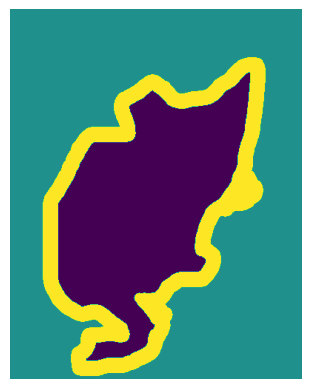

In [3]:
load_img(input_img_paths[2])
def display_target(img):
    normalized_img = (img.astype("uint8") - 1) * 127 # 0-255
    plt.axis("off")
    plt.imshow(normalized_img[:, :, 0])

img = load_img(target_img_paths[2], color_mode='grayscale')
img = img_to_array(img)
display_target(img)

## **Step 5: Define Preprocessing Functions**

Define helper functions for loading, resizing, and normalizing images and masks. Normalization scales pixel values to a range of [0, 1], which accelerates training convergence.

In [ ]:
img_size = (256, 256)  # Increased image size for better resolution

def path_to_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0, 1]
    return img

def path_to_target(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.uint8) - 1
    return img

def map_fn(img_path, target_path):
    img = path_to_img(img_path)
    mask = path_to_target(target_path)
    return img, mask

# **Step 6: Data Augmentation**

Apply data augmentation techniques like flipping, adjusting brightness, and contrast. This improves model generalization by exposing it to varied versions of each image.



In [ ]:

def augment_data(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, mask

## **Step 7: Prepare Dataset**

Prepare the datasets for training and validation, applying augmentation only to the training set. The prefetch method optimizes data loading.

In [ ]:
def prepare_dataset(image_paths, mask_paths, batch_size, should_augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    if should_augment:
        dataset = dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

num_valid_samples = 1000
train_dataset = prepare_dataset(input_img_paths[:-num_valid_samples], 
                                target_img_paths[:-num_valid_samples], 
                                batch_size=32, should_augment=True)

valid_dataset = prepare_dataset(input_img_paths[-num_valid_samples:], 
                                target_img_paths[-num_valid_samples:], 
                                batch_size=32, should_augment=False)

## **Step 8: Build the U-Net Model**

The U-Net model consists of an encoder and a decoder. The encoder extracts features from the input, while the decoder upsamples and reconstructs the output mask.


In [4]:
def unet_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    
    # Encoder (Downsampling)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bridge
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder (Upsampling)
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.concatenate([up5, conv3])
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    up6 = layers.concatenate([up6, conv2])
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = layers.concatenate([up7, conv1])
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model

num_classes = 3
# model = unet_model(img_size,img_size[0], num_classes)
model = unet_model(img_size, num_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]  

 Total params: 7,783,043 (29.69 MB)

 Trainable params: 7,783,043 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

## **Step 9: Compile the Model with Optimizer, Early Stopping, and Learning Rate Adjustment**

Initialize an Adam optimizer with a fixed learning rate of  0.0001. Adam is chosen for its adaptive learning rate capability, which helps the model converge faster. Instead of a dynamic decay schedule, we rely on callback functions to adjust the learning rate when the model’s performance plateaus.

### Callback Functions for Optimized Training

The following callbacks ensure efficient training and prevent overfitting:

- **ModelCheckpoint**: Saves the model’s weights only when there is an improvement in validation accuracy, ensuring that we retain the best-performing model.
  
- **ReduceLROnPlateau**: Adjusts the learning rate dynamically. If the model’s validation accuracy plateaus for 5 epochs, the learning rate is reduced by a factor of 0.5 (halved). This lower learning rate allows the model to make finer updates, potentially escaping local minima. The minimum learning rate (`min_lr=1e-6`) ensures that the learning rate won’t go too low, preventing overly slow training.

- **EarlyStopping**: Monitors the validation loss and halts training if no improvement is seen after 10 epochs. By restoring the best weights (`restore_best_weights=True`), we ensure that the model’s performance is the best achieved during training, reducing overfitting.


Train the model for up to 60 epochs with the defined callbacks. The combination of early stopping and learning rate reduction allows the model to maximize accuracy while preventing overfitting and unnecessary training steps.



In [5]:
initial_learning_rate = 1e-4

optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation_unet.keras", save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                      factor=0.5, 
                                      patience=5, 
                                      min_lr=1e-6, 
                                      verbose=1),
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

history = model.fit(train_dataset,
                    epochs=60,
                    callbacks=callbacks,
                    validation_data=valid_dataset)

Epoch 1/60



I0000 00:00:1730901483.149078      79 service.cc:145] XLA service 0x7c939c002020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:

I0000 00:00:1730901483.149146      79 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5

I0000 00:00:1730901483.149152      79 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5

W0000 00:00:1730901483.749724      79 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert

2024-11-06 13:58:42.033756: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng9{k2=0,k4=2,k5=1,k6=0,k7=0} for conv (f32[32,192,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,256,256]{3,2,1,0}, f32[64,192,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:02 1s/step - accuracy: 0.5435 - loss: 0.9836

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:49 1s/step - accuracy: 0.5467 - loss: 0.9759

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


199/200 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5738 - loss: 0.9231

W0000 00:00:1730901818.643132      77 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5741 - loss: 0.9227

W0000 00:00:1730901905.480753      76 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert

W0000 00:00:1730901916.957291      79 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


200/200 ━━━━━━━━━━━━━━━━━━━━ 452s 2s/step - accuracy: 0.5743 - loss: 0.9223 - val_accuracy: 0.6646 - val_loss: 0.7699 - learning_rate: 1.0000e-04

Epoch 2/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:03 1s/step - accuracy: 0.6454 - loss: 0.8129

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.6463 - loss: 0.8108

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.6584 - loss: 0.7859 - val_accuracy: 0.6763 - val_loss: 0.7622 - learning_rate: 1.0000e-04

Epoch 3/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:03 1s/step - accuracy: 0.6759 - loss: 0.7627

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.6779 - loss: 0.7590

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.6921 - loss: 0.7302 - val_accuracy: 0.7045 - val_loss: 0.6938 - learning_rate: 1.0000e-04

Epoch 4/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.6869 - loss: 0.7451

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.6890 - loss: 0.7401

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.7060 - loss: 0.7030 - val_accuracy: 0.7262 - val_loss: 0.6457 - learning_rate: 1.0000e-04

Epoch 5/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.7135 - loss: 0.6917

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.7146 - loss: 0.6886

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.7265 - loss: 0.6611 - val_accuracy: 0.7582 - val_loss: 0.5701 - learning_rate: 1.0000e-04

Epoch 6/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.7196 - loss: 0.6673

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.7204 - loss: 0.6656

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.7323 - loss: 0.6415 - val_accuracy: 0.7747 - val_loss: 0.5422 - learning_rate: 1.0000e-04

Epoch 7/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.7256 - loss: 0.6499

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.7262 - loss: 0.6485

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.7386 - loss: 0.6239 - val_accuracy: 0.7831 - val_loss: 0.5271 - learning_rate: 1.0000e-04

Epoch 8/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.7541 - loss: 0.6028

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.7547 - loss: 0.6011

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.7637 - loss: 0.5806 - val_accuracy: 0.7803 - val_loss: 0.5304 - learning_rate: 1.0000e-04

Epoch 9/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.7583 - loss: 0.5946

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.7593 - loss: 0.5922

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.7694 - loss: 0.5687 - val_accuracy: 0.7972 - val_loss: 0.4975 - learning_rate: 1.0000e-04

Epoch 10/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.7707 - loss: 0.5624

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.7714 - loss: 0.5610

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.7800 - loss: 0.5426 - val_accuracy: 0.7908 - val_loss: 0.5161 - learning_rate: 1.0000e-04

Epoch 11/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.7710 - loss: 0.5705

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.7721 - loss: 0.5677

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.7821 - loss: 0.5437 - val_accuracy: 0.7985 - val_loss: 0.4960 - learning_rate: 1.0000e-04

Epoch 12/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.7722 - loss: 0.5654

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.7730 - loss: 0.5635

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.7824 - loss: 0.5418 - val_accuracy: 0.7976 - val_loss: 0.4989 - learning_rate: 1.0000e-04

Epoch 13/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.7800 - loss: 0.5512

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.7811 - loss: 0.5483

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.7909 - loss: 0.5239 - val_accuracy: 0.8102 - val_loss: 0.4760 - learning_rate: 1.0000e-04

Epoch 14/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.7867 - loss: 0.5356

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.7871 - loss: 0.5344

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.7945 - loss: 0.5158 - val_accuracy: 0.8221 - val_loss: 0.4474 - learning_rate: 1.0000e-04

Epoch 15/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.7938 - loss: 0.5207

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.7942 - loss: 0.5193

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.8010 - loss: 0.5019 - val_accuracy: 0.8301 - val_loss: 0.4295 - learning_rate: 1.0000e-04

Epoch 16/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.8025 - loss: 0.5013

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.8031 - loss: 0.4993

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.8100 - loss: 0.4811 - val_accuracy: 0.8166 - val_loss: 0.4558 - learning_rate: 1.0000e-04

Epoch 17/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.8034 - loss: 0.4992

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8042 - loss: 0.4970

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.8116 - loss: 0.4777 - val_accuracy: 0.8344 - val_loss: 0.4192 - learning_rate: 1.0000e-04

Epoch 18/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.8090 - loss: 0.4836

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.8097 - loss: 0.4817

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.8168 - loss: 0.4640 - val_accuracy: 0.8258 - val_loss: 0.4383 - learning_rate: 1.0000e-04

Epoch 19/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.8119 - loss: 0.4785

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8126 - loss: 0.4766

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.8195 - loss: 0.4590 - val_accuracy: 0.8309 - val_loss: 0.4287 - learning_rate: 1.0000e-04

Epoch 20/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.8179 - loss: 0.4642

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8186 - loss: 0.4625

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.8247 - loss: 0.4463 - val_accuracy: 0.8284 - val_loss: 0.4433 - learning_rate: 1.0000e-04

Epoch 21/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.8166 - loss: 0.4680

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.8174 - loss: 0.4660

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.8246 - loss: 0.4474 - val_accuracy: 0.8472 - val_loss: 0.3907 - learning_rate: 1.0000e-04

Epoch 22/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.8213 - loss: 0.4520

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8219 - loss: 0.4506

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.8283 - loss: 0.4352 - val_accuracy: 0.8388 - val_loss: 0.4133 - learning_rate: 1.0000e-04

Epoch 23/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.8253 - loss: 0.4438

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8262 - loss: 0.4416

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.8332 - loss: 0.4247 - val_accuracy: 0.8470 - val_loss: 0.3920 - learning_rate: 1.0000e-04

Epoch 24/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.8250 - loss: 0.4515

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.8256 - loss: 0.4495

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.8322 - loss: 0.4313 - val_accuracy: 0.8417 - val_loss: 0.4015 - learning_rate: 1.0000e-04

Epoch 25/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.8266 - loss: 0.4427

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.8273 - loss: 0.4408

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.8341 - loss: 0.4237 - val_accuracy: 0.8546 - val_loss: 0.3729 - learning_rate: 1.0000e-04

Epoch 26/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.8251 - loss: 0.4528

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.8255 - loss: 0.4513

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.8317 - loss: 0.4337 - val_accuracy: 0.8573 - val_loss: 0.3671 - learning_rate: 1.0000e-04

Epoch 27/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.8378 - loss: 0.4143

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8383 - loss: 0.4131

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.8431 - loss: 0.4007 - val_accuracy: 0.8560 - val_loss: 0.3693 - learning_rate: 1.0000e-04

Epoch 28/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.8415 - loss: 0.4055

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.8420 - loss: 0.4042

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.8465 - loss: 0.3924 - val_accuracy: 0.8626 - val_loss: 0.3525 - learning_rate: 1.0000e-04

Epoch 29/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.8437 - loss: 0.3984

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8440 - loss: 0.3976

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.8485 - loss: 0.3868 - val_accuracy: 0.8602 - val_loss: 0.3588 - learning_rate: 1.0000e-04

Epoch 30/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.8447 - loss: 0.3978

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.8452 - loss: 0.3966

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.8501 - loss: 0.3840 - val_accuracy: 0.8556 - val_loss: 0.3678 - learning_rate: 1.0000e-04

Epoch 31/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.8493 - loss: 0.3870

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.8497 - loss: 0.3859

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.8540 - loss: 0.3748 - val_accuracy: 0.8579 - val_loss: 0.3645 - learning_rate: 1.0000e-04

Epoch 32/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.8520 - loss: 0.3809

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.8524 - loss: 0.3796

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.8567 - loss: 0.3682 - val_accuracy: 0.8667 - val_loss: 0.3418 - learning_rate: 1.0000e-04

Epoch 33/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.8533 - loss: 0.3760

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8538 - loss: 0.3748

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.8582 - loss: 0.3636 - val_accuracy: 0.8665 - val_loss: 0.3449 - learning_rate: 1.0000e-04

Epoch 34/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.8530 - loss: 0.3766

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.8532 - loss: 0.3759

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.8574 - loss: 0.3651 - val_accuracy: 0.8702 - val_loss: 0.3325 - learning_rate: 1.0000e-04

Epoch 35/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.8538 - loss: 0.3776

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.8541 - loss: 0.3767

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.8586 - loss: 0.3646 - val_accuracy: 0.8684 - val_loss: 0.3377 - learning_rate: 1.0000e-04

Epoch 36/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.8600 - loss: 0.3634

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.8603 - loss: 0.3625

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.8640 - loss: 0.3519 - val_accuracy: 0.8750 - val_loss: 0.3202 - learning_rate: 1.0000e-04

Epoch 37/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.8645 - loss: 0.3498

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8647 - loss: 0.3493

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.8675 - loss: 0.3414 - val_accuracy: 0.8696 - val_loss: 0.3404 - learning_rate: 1.0000e-04

Epoch 38/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.8650 - loss: 0.3480

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8652 - loss: 0.3474

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.8684 - loss: 0.3389 - val_accuracy: 0.8635 - val_loss: 0.3527 - learning_rate: 1.0000e-04

Epoch 39/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.8661 - loss: 0.3454

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8664 - loss: 0.3446

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.8702 - loss: 0.3348 - val_accuracy: 0.8714 - val_loss: 0.3312 - learning_rate: 1.0000e-04

Epoch 40/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.8674 - loss: 0.3424

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8677 - loss: 0.3417

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.8711 - loss: 0.3326 - val_accuracy: 0.8737 - val_loss: 0.3239 - learning_rate: 1.0000e-04

Epoch 41/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.8678 - loss: 0.3409

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8682 - loss: 0.3400

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8720 - loss: 0.3300

Epoch 41: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

200/200 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.8720 - loss: 0.3299 - val_accuracy: 0.8673 - val_loss: 0.3439 - learning_rate: 1.0000e-04

Epoch 42/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.8723 - loss: 0.3310

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8729 - loss: 0.3296

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.8768 - loss: 0.3189 - val_accuracy: 0.8761 - val_loss: 0.3230 - learning_rate: 5.0000e-05

Epoch 43/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.8722 - loss: 0.3333

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8728 - loss: 0.3314

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.8773 - loss: 0.3186 - val_accuracy: 0.8767 - val_loss: 0.3209 - learning_rate: 5.0000e-05

Epoch 44/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.8747 - loss: 0.3261

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8753 - loss: 0.3244

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.8795 - loss: 0.3126 - val_accuracy: 0.8817 - val_loss: 0.3096 - learning_rate: 5.0000e-05

Epoch 45/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.8783 - loss: 0.3159

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8788 - loss: 0.3145

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.8824 - loss: 0.3045 - val_accuracy: 0.8802 - val_loss: 0.3145 - learning_rate: 5.0000e-05

Epoch 46/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.8798 - loss: 0.3133

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8803 - loss: 0.3119

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.8837 - loss: 0.3019 - val_accuracy: 0.8854 - val_loss: 0.2988 - learning_rate: 5.0000e-05

Epoch 47/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.8828 - loss: 0.3053

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8831 - loss: 0.3042

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.8860 - loss: 0.2958 - val_accuracy: 0.8865 - val_loss: 0.2971 - learning_rate: 5.0000e-05

Epoch 48/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.8840 - loss: 0.3013

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8843 - loss: 0.3004

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.8872 - loss: 0.2924 - val_accuracy: 0.8866 - val_loss: 0.2978 - learning_rate: 5.0000e-05

Epoch 49/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.8833 - loss: 0.3033

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8837 - loss: 0.3022

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.8870 - loss: 0.2930 - val_accuracy: 0.8867 - val_loss: 0.2993 - learning_rate: 5.0000e-05

Epoch 50/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.8858 - loss: 0.2974

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8862 - loss: 0.2963

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.8891 - loss: 0.2878 - val_accuracy: 0.8871 - val_loss: 0.2968 - learning_rate: 5.0000e-05

Epoch 51/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.8864 - loss: 0.2955

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8866 - loss: 0.2947

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.8893 - loss: 0.2871 - val_accuracy: 0.8871 - val_loss: 0.2979 - learning_rate: 5.0000e-05

Epoch 52/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.8880 - loss: 0.2915

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8883 - loss: 0.2908

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.8909 - loss: 0.2831 - val_accuracy: 0.8885 - val_loss: 0.2959 - learning_rate: 5.0000e-05

Epoch 53/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.8891 - loss: 0.2878

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8894 - loss: 0.2871

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.8921 - loss: 0.2796 - val_accuracy: 0.8885 - val_loss: 0.2959 - learning_rate: 5.0000e-05

Epoch 54/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.8903 - loss: 0.2869

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8905 - loss: 0.2861

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.8929 - loss: 0.2787 - val_accuracy: 0.8881 - val_loss: 0.2971 - learning_rate: 5.0000e-05

Epoch 55/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.8923 - loss: 0.2822

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8925 - loss: 0.2816

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.8947 - loss: 0.2744 - val_accuracy: 0.8894 - val_loss: 0.2925 - learning_rate: 5.0000e-05

Epoch 56/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.8919 - loss: 0.2818

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8921 - loss: 0.2811

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.8948 - loss: 0.2734 - val_accuracy: 0.8884 - val_loss: 0.2954 - learning_rate: 5.0000e-05

Epoch 57/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.8929 - loss: 0.2794

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:52 1s/step - accuracy: 0.8932 - loss: 0.2786

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.8959 - loss: 0.2706 - val_accuracy: 0.8876 - val_loss: 0.2999 - learning_rate: 5.0000e-05

Epoch 58/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.8947 - loss: 0.2749

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.8950 - loss: 0.2740

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.8977 - loss: 0.2662 - val_accuracy: 0.8876 - val_loss: 0.3018 - learning_rate: 5.0000e-05

Epoch 59/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.8947 - loss: 0.2746

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:52 1s/step - accuracy: 0.8950 - loss: 0.2737

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.8979 - loss: 0.2654 - val_accuracy: 0.8875 - val_loss: 0.3035 - learning_rate: 5.0000e-05

Epoch 60/60

 91/200 ━━━━━━━━━━━━━━━━━━━━ 2:06 1s/step - accuracy: 0.8954 - loss: 0.2734

Corrupt JPEG data: premature end of data segment


103/200 ━━━━━━━━━━━━━━━━━━━━ 1:52 1s/step - accuracy: 0.8957 - loss: 0.2724

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8985 - loss: 0.2642

Epoch 60: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

200/200 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.8985 - loss: 0.2641 - val_accuracy: 0.8880 - val_loss: 0.2999 - learning_rate: 5.0000e-05


## **Step 10: Visualize Training History**

Plot training and validation loss and accuracy to understand the model’s performance over time.

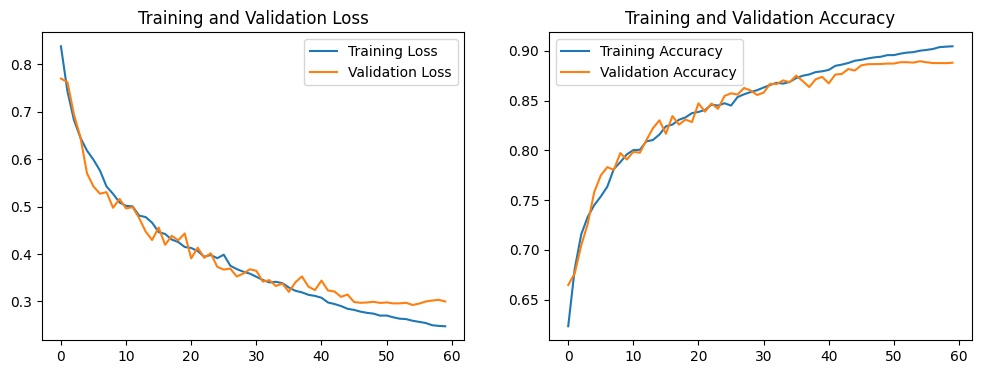

In [6]:
# Plotting training history
plt.figure(figsize=(12,4))
plt.subplot(1 , 2 ,1 )
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1 , 2 ,2 )
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## **Step 11: Load Best Model and Make & visualize Predictions**

Load the best model based on validation performance, as saved by the ModelCheckpoint callback, to use in predictions.

Display the input image, ground truth mask, and predicted mask to visually assess the model's segmentation quality.

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


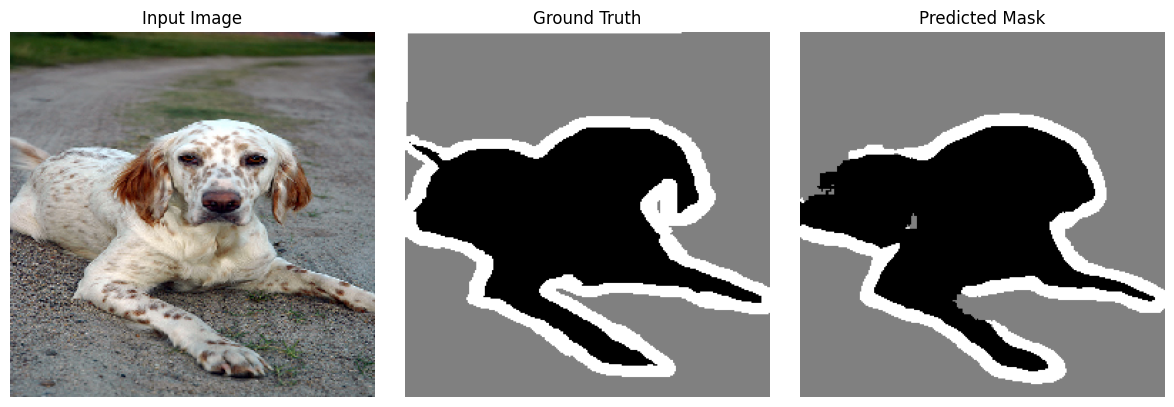

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


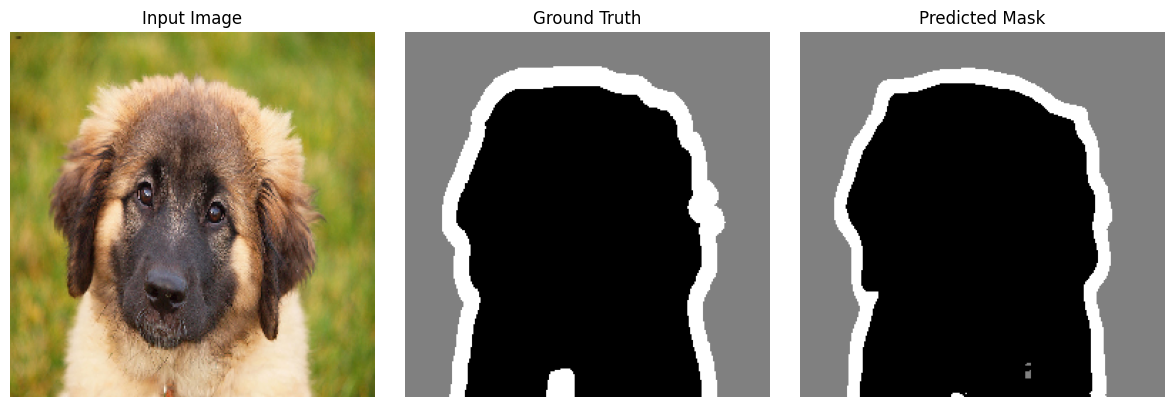

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


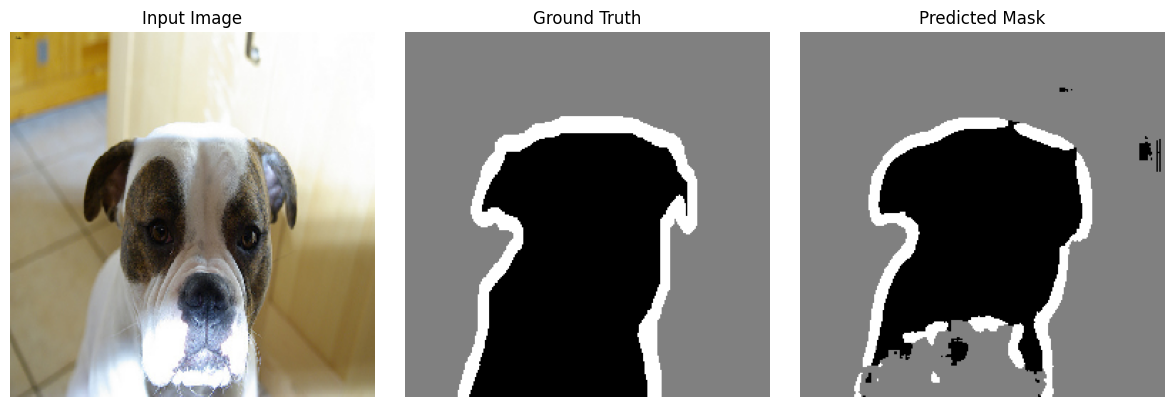

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


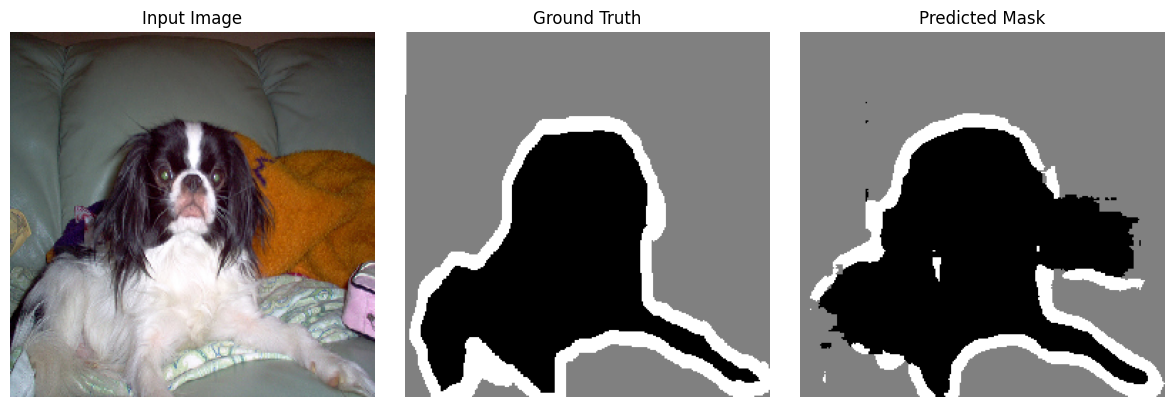

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


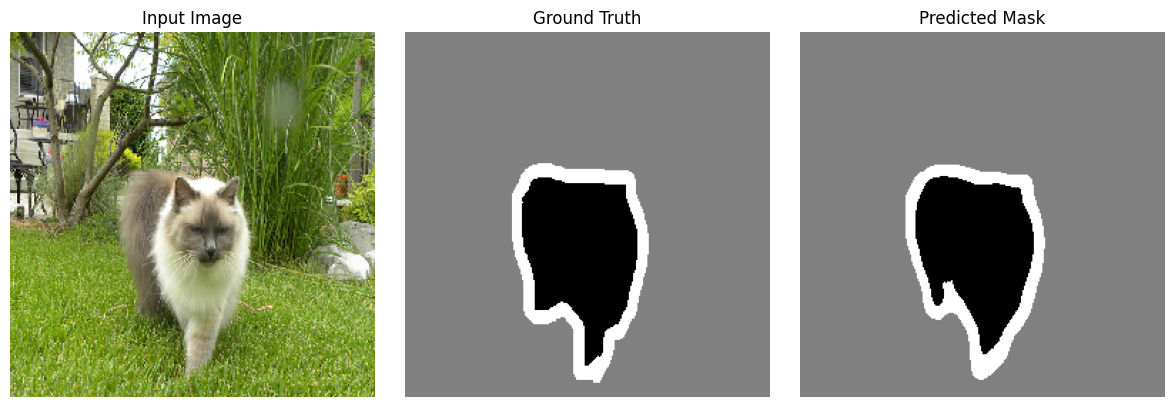

In [7]:
# Load the best model and make predictions
model=keras.models.load_model("oxford_segmentation_unet.keras")

def display_mask(pred):
   mask=np.argmax(pred , axis=-1)
   mask*=127
   return mask

# Visualize predictions
num_display=5
for i in range(num_display):
   idx=np.random.randint(len(input_img_paths))
   test_image=load_img(input_img_paths[idx], target_size=img_size)
   test_image_array=img_to_array(test_image)/255.0

   mask=model.predict(np.expand_dims(test_image_array , axis=0))[0]

   plt.figure(figsize=(12 ,4 ))
   plt.subplot(1 ,3 ,1 )
   plt.title("Input Image")
   plt.imshow(test_image )
   plt.axis("off")

   plt.subplot(1 ,3 ,2 )
   plt.title("Ground Truth")
   gt_mask=load_img(target_img_paths[idx], target_size=img_size , color_mode="grayscale")
   plt.imshow(gt_mask , cmap="gray")
   plt.axis("off")

   plt.subplot(1 ,3 ,3 )
   plt.title("Predicted Mask")
   plt.imshow(display_mask(mask), cmap="gray")
   plt.axis("off")

   plt.tight_layout()
   plt.show()

## **Conclusion**
In this notebook, we trained a U-Net model for pet segmentation using the Oxford Pets dataset. Key techniques like data augmentation, learning rate scheduling, and early stopping were crucial in achieving accurate and efficient training.
